In [166]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [167]:
layer_num=4
hidden_num=128

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=512):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [168]:
def potential(x):
    poten=x*torch.sin(torch.pi*x/2.5)*10+x**4/25
    return poten

In [169]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
La=-10
Lb =10
L=Lb-La  # domain length
N = 3000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=30
extend_num=0
epoch=50000
lr=0.01
# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


/tmp/ipykernel_2444325/2513471731.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


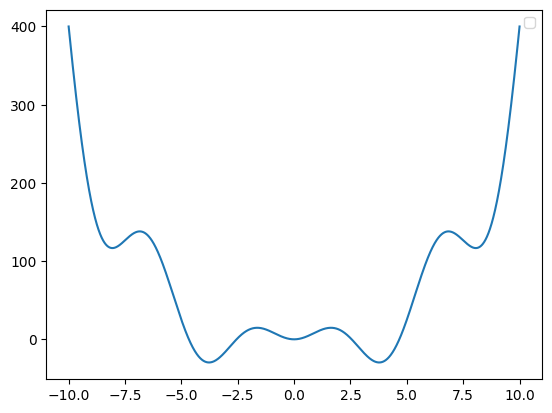

In [170]:
# 势函数演示图像
x_test=torch.linspace(La, Lb, N+2)
f1_test=potential(x_test)
plt.plot(x_test.numpy(), f1_test.numpy())
plt.legend()
plt.show()

In [171]:
# 计算初始的本征值
V_diag=potential(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

print('initial eigenvalues check:')
print(eigenvalues[:en_num])

initial eigenvalues check:
tensor([-25.5775, -25.5774, -17.6892, -17.6891, -10.1361, -10.1360,  -2.9692,
         -2.9690,   2.4016,   3.7313,   3.7327,   6.9734,   9.7985,   9.7991,
         11.0023,  13.9661,  14.7494,  15.3219,  17.2688,  18.9108,  20.4834,
         22.3310,  24.2866,  26.3091,  28.4237,  30.6195,  32.8902,  35.2292,
         37.6341,  40.1018], device='cuda:5', grad_fn=<SliceBackward0>)


In [172]:
######----------------------------------------------
real_en=eigenvalues[:en_num].detach()
######----------------------------------------------

In [173]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=50,threshold=1e-4)
loss_fn=nn.MSELoss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    
    output=eigenvalues[:en_num]
    
    val_loss=loss_fn(output,real_en)
    loss=val_loss
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    
    os.makedirs(f'./fun_images/V_{La}_{Lb}_{N}_{en_num}', exist_ok=True)
    torch.save(V_diag,f'./fun_images/V_{La}_{Lb}_{N}_{en_num}/V_diag_{i}.pth')
    
    if i%10==0:
        # clear_output(wait=True)
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        print('\nepoch:',i)
        print(eigenvalues[:en_num+extend_num])
        print(real_en)
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')
    
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
final_loss=loss.item()
final_time_cost=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')


epoch:0,loss:263.4463806152344,time:0.06861186027526855,lr:0.01

epoch: 0
tensor([ 0.2880,  0.3972,  0.4897,  0.5728,  0.7028,  0.8422,  0.9959,  1.1773,
         1.3877,  1.6215,  1.8859,  2.1698,  2.4709,  2.8044,  3.1665,  3.5494,
         3.9548,  4.3870,  4.8461,  5.3260,  5.8264,  6.3552,  6.9123,  7.4929,
         8.0973,  8.7261,  9.3810, 10.0610, 10.7626, 11.4891], device='cuda:5',
       grad_fn=<SliceBackward0>)
tensor([-25.5775, -25.5774, -17.6892, -17.6891, -10.1361, -10.1360,  -2.9692,
         -2.9690,   2.4016,   3.7313,   3.7327,   6.9734,   9.7985,   9.7991,
         11.0023,  13.9661,  14.7494,  15.3219,  17.2688,  18.9108,  20.4834,
         22.3310,  24.2866,  26.3091,  28.4237,  30.6195,  32.8902,  35.2292,
         37.6341,  40.1018], device='cuda:5')
epoch:10,loss:1099.624267578125,time:0.7003509998321533,lr:0.01

epoch: 10
tensor([-41.0432, -28.6847, -16.5676,  -5.8722,   3.9857,  12.3553,  19.3091,
         25.0821,  29.9833,  34.2682,  37.9579,  41.1832,  44.

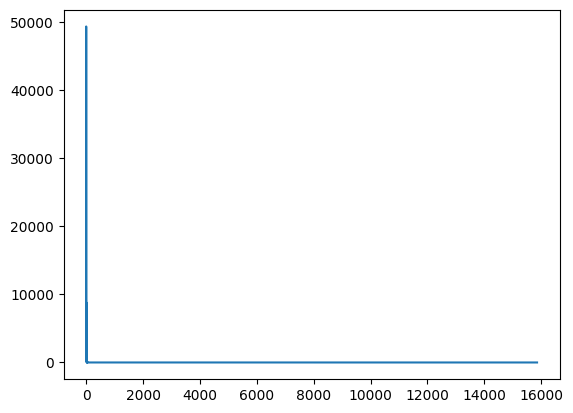

In [174]:
plt.plot(loss_list)
plt.show()

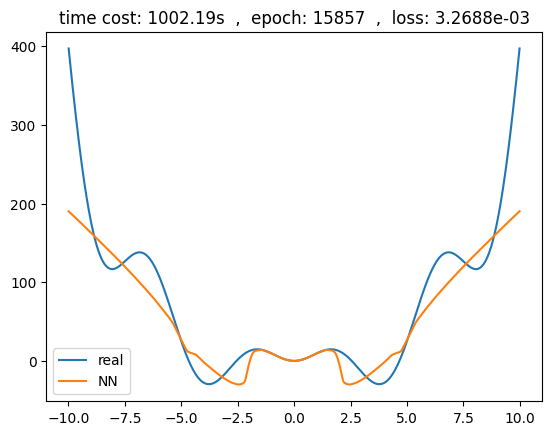

In [175]:
La=-10
Lb =10
L=Lb-La  # domain length
N = 2000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_NN=model(grid)
V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid)
real_poten=real_poten.cpu().detach().numpy()
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.title(f'time cost: {final_time_cost:.2f}s  ,  epoch: {final_epoch}  ,  loss: {final_loss:.4e}')
plt.legend()
plt.show()

In [176]:
# os.makedirs(f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
# torch.save(V_NN,f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}/V_NN_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')

In [177]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 24.626156
max_error: 206.93793
